## Tutorial 2: Mixture Models and Expectation Maximization

### Exercise 1: Categorical Mixture Model (CMM)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt

import gensim
from wordcloud import WordCloud, STOPWORDS

from categorical_em import CategoricalEM

#### 1.4) Play around with the dataset

##### Load and pre-process the data
Load the data from the tweets_cleaned csv file as `pandas` dataframe. It contains the documents already pre-processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatisation.
3. Cleaning
4. Vectorization

In [2]:
df = pd.read_csv('tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)  # drop duplicates tweets
df['tokens'] = df['tokens'].apply(literal_eval)  # transform the string into a list of tokens
X_tokens = list(df['tokens'].values)

In [3]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


##### Create the dictionary
We have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection of words which are the most relevant according to the semantic analysis. 

We now convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). For this purpose we use the `gensim` library.

In [4]:
I = 120  # hyperparameter: number of different words to keep

In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)
print(dictionary)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)
print(dictionary)

Dictionary(12243 unique tokens: ['collin', 'cum', 'domin', 'phil', 'room']...)
Dictionary(120 unique tokens: ['look', 'peopl', 'woman', 'love', 'work']...)


##### Create Bag of Words (BoW)
Let's create the numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]
N = len(df_data)

##### Create the matrix
Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the n-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the n-th document. This will be the matrix used in the algorithm.

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]
X_matrix.shape

(5568, 120)

#### 1.5) Implement the EM algorithm

In [8]:
K = 6  # hyperparameter: number of topics
i_theta = 1
i_pi = 1
model = CategoricalEM(K, I, N, delta=0.01, epochs=200, init_params={'theta': i_theta, 'pi': i_pi})
model.fit(X_matrix)


ITER: 0 Q= -115633.6841 diff= 200
ITER: 5 Q= -104752.3399 diff= 644.3929
ITER: 10 Q= -103523.2635 diff= 121.6231
ITER: 15 Q= -103178.5907 diff= 47.806
ITER: 20 Q= -102993.0518 diff= 24.4851
ITER: 25 Q= -102921.4326 diff= 9.2681
ITER: 30 Q= -102893.9936 diff= 3.2741
ITER: 35 Q= -102888.0141 diff= 0.1591
ITER: 36 Q= -102888.1505 diff= -0.1364


#### 1.6) Show the ten most representative words for each topic using a wordcloud, and the ten most relevant documents for each topic

Words per topic

In [9]:
argsort = np.argsort(model.theta_matrix, axis=1)
argsort = [x[::-1] for x in argsort]

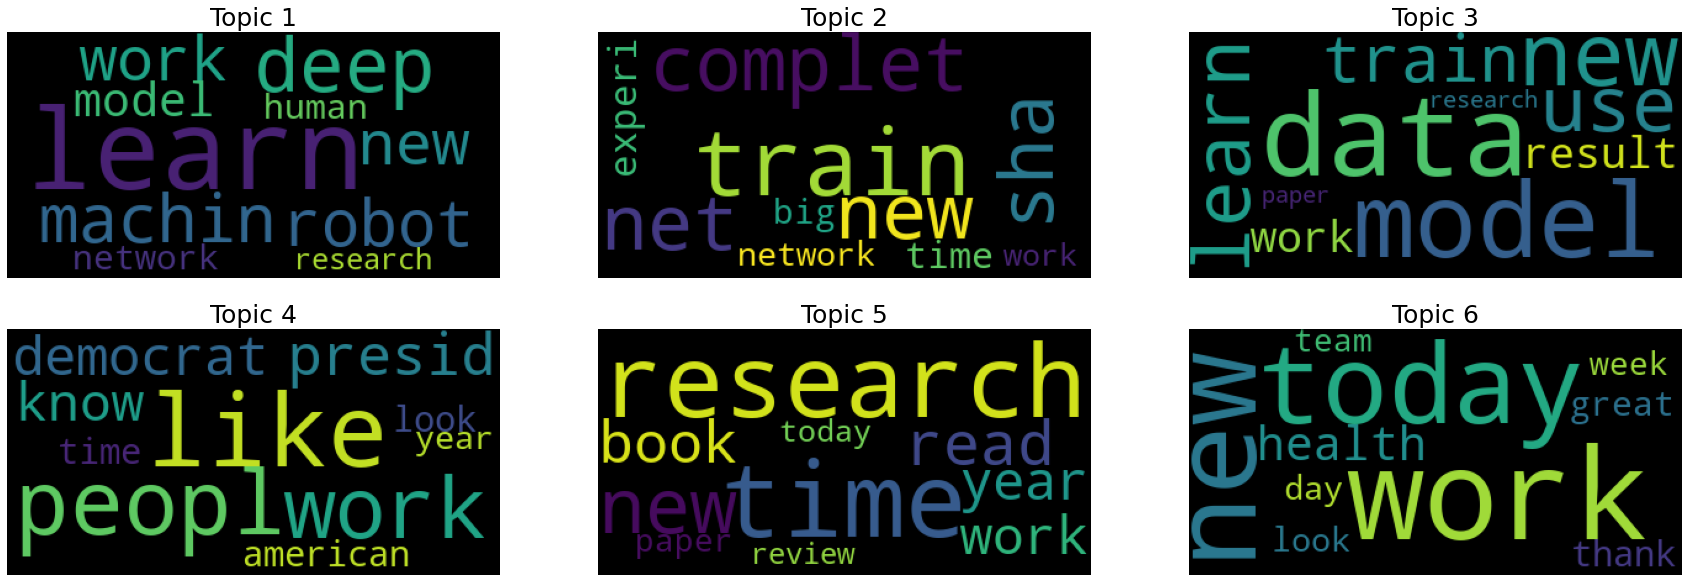

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(30, 10))
for k in range(K):
    words = [(dictionary[m], model.theta_matrix[k][m]) for m in argsort[k][:10]]
    axs[k//3,k%3].imshow(WordCloud().fit_words(dict(words)))
    axs[k//3,k%3].set_title(f'Topic {k+1}', fontsize=25)
    axs[k//3,k%3].axis('off')

Documents per topic

In [11]:
rnk = model.r_matrix.T
rnk.shape

(6, 5568)

In [12]:
argsort = np.argsort(rnk, axis=1)
argsort = [x[::-1][:10] for x in argsort] 

In [13]:
# topic 1
df_data.iloc[argsort[0]]

,tweet_id,timestamp,user_id,tweet,tweets_clean,tokens
4336,1174288818167566336,1.568807e+09,1482581556,Really pleased to see @Cambridge_CL announce P...,really pleased to see announce prof neil lawre...,"[pleas, announc, prof, neil, lawrenc, deepmind..."
3104,1128504973300383744,1.557892e+09,911297187664949248,I'm looking forward to speaking about the pote...,i m looking forward to speaking about the pote...,"[look, forward, speak, potenti, machin, learn,..."
4191,1179799147487956992,1.570121e+09,4783690002,Machine learning systems are increasingly used...,machine learning systems are increasingly used...,"[machin, learn, system, increas, decis, far, r..."
2326,1017979497633730561,1.531540e+09,990433714948661250,Some more talks from our group on Sun at #ICML...,some more talks from our group on sun at icml2...,"[talk, group, sun, icml, erl, abhishek, meta, ..."
2269,1130699525335670784,1.558415e+09,990433714948661250,Can dexterous robots learn to perform complex ...,can dexterous robots learn to perform complex ...,"[dexter, robot, learn, perform, complex, task,..."
3110,1144719555106787330,1.561757e+09,175282603,Learn:\n- Practical Deep Learning http://cour...,learn practical deep learning deep lear...,"[learn, practic, deep, learn, deep, learn, fou..."
2290,1118353299030233088,1.555471e+09,990433714948661250,"Deep RL from images, w/o manual reward design:...",deep rl from images w o manual reward design ...,"[deep, imag, manual, reward, design, new, work..."
2323,1020331207618322433,1.532101e+09,990433714948661250,"Deep RL, from images, conditioned on user-spec...",deep rl from images conditioned on user spec...,"[deep, imag, condit, user, specifi, goal, trai..."
2279,1126165878431735809,1.557334e+09,990433714948661250,How can RL agents learn to learn online? Deep ...,how can rl agents learn to learn online deep ...,"[agent, learn, learn, onlin, deep, onlin, lear..."
2287,1124366225214033925,1.556905e+09,990433714948661250,Podcast conversation I had with @craigss about...,podcast conversation i had with about robotic ...,"[podcast, convers, robot, learn, touch, sens, ..."
